In [1]:
import glob2
import os
from random import randint
from IPython.core.display import Image, display
import numpy as np
import numpy as np
import tensorflow as tf
import scipy.ndimage as ndi
from skimage import transform,io
import cv2

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
training_path = "/whhdata/person/MH_WHH_0153/measurements/1537860868501/rgb/"
#training_path = ""

glob_search_path = os.path.join(training_path, "**/rgb_MH_WHH_0153_1537860868501_104_95407.100099759.jpg")
jpg_paths = glob2.glob(glob_search_path)
print("jpg_paths", len(jpg_paths))

jpg_paths 1


In [3]:
index = randint(0,len(jpg_paths)-1)
img_filename = jpg_paths[index]
print("File %s: %s" % (index, img_filename))
#display(Image(filename=img_filename, width=257, height=353))

File 0: /whhdata/person/MH_WHH_0153/measurements/1537860868501/rgb/rgb_MH_WHH_0153_1537860868501_104_95407.100099759.jpg


In [4]:
img = cv2.imread(img_filename)
print(type(img))
print(img.shape)
img_rotate_90_clockwise = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
cv2.imwrite('90roation.jpg', img_rotate_90_clockwise)

<class 'numpy.ndarray'>
(1080, 1920, 3)


True

In [5]:
from PIL import Image
colorImage  = Image.open(img_filename)
transposed  = colorImage.transpose(Image.ROTATE_90)

In [6]:
image = io.imread("90roation.jpg")

In [7]:
training_path = ""

glob_search_path = os.path.join(training_path, "**/*.jpg")
jpg_paths = glob2.glob(glob_search_path)
print("jpg_paths", len(jpg_paths))

jpg_paths 1


In [8]:
index = randint(0,len(jpg_paths)-1)
img_filename = jpg_paths[index]
print("File %s: %s" % (index, img_filename))

File 0: 90roation.jpg


In [9]:
def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

In [10]:

import PIL.Image
#from cStringIO import StringIO
import io
import IPython.display
import numpy as np
def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = io.StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

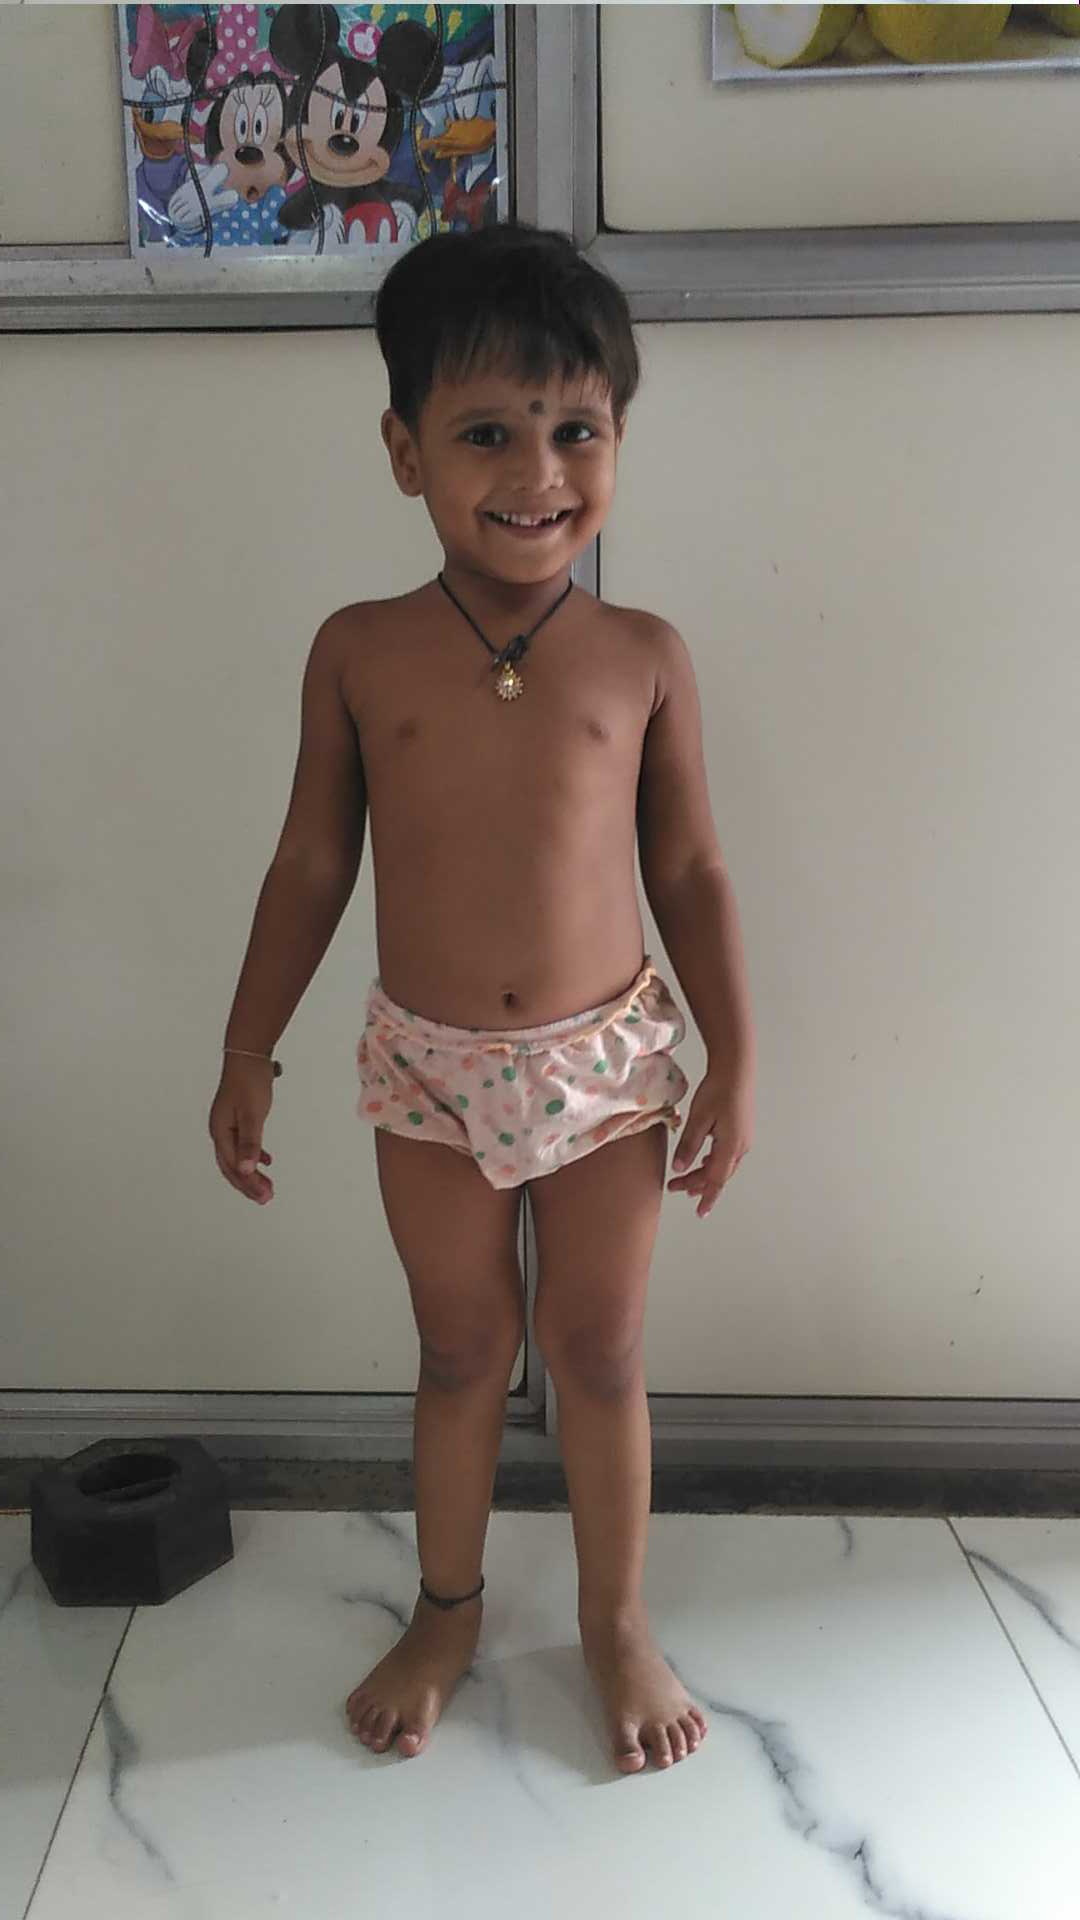

In [11]:
PIL.Image.fromarray(image)

In [12]:
import tensorflow as tf
import cv2
import time
import argparse
import os



In [13]:
MODEL_DIR = './_models'

def load_model(model_id, sess, model_dir=MODEL_DIR):
    model_path = os.path.join(model_dir, 'model-mobilenet_v1_101.pb')

    with tf.gfile.GFile(model_path, 'rb') as f:
        graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')

    offsets = sess.graph.get_tensor_by_name('offset_2:0')
    displacement_fwd = sess.graph.get_tensor_by_name('displacement_fwd_2:0')
    displacement_bwd = sess.graph.get_tensor_by_name('displacement_bwd_2:0')
    heatmaps = sess.graph.get_tensor_by_name('heatmap:0')

    return [heatmaps, offsets, displacement_fwd, displacement_bwd]


In [14]:
def valid_resolution(width, height, output_stride=16):
    target_width = (int(width) // output_stride) * output_stride + 1
    target_height = (int(height) // output_stride) * output_stride + 1
    return target_width, target_height


def _process_input(source_img, scale_factor=1.0, output_stride=16):
    target_width, target_height = valid_resolution(
        source_img.shape[1] * scale_factor, source_img.shape[0] * scale_factor, output_stride=output_stride)
    scale = np.array([source_img.shape[0] / target_height, source_img.shape[1] / target_width])

    input_img = cv2.resize(source_img, (target_width, target_height), interpolation=cv2.INTER_LINEAR)
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB).astype(np.float32)
    input_img = input_img * (2.0 / 255.0) - 1.0
    input_img = input_img.reshape(1, target_height, target_width, 3)
    return input_img, source_img, scale


def read_imgfile(path, scale_factor=1.0, output_stride=16):
    img = cv2.imread(path)
    return _process_input(img, scale_factor, output_stride)

In [15]:
def within_nms_radius_fast(pose_coords, squared_nms_radius, point):
    if not pose_coords.shape[0]:
        return False
    return np.any(np.sum((pose_coords - point) ** 2, axis=1) <= squared_nms_radius)

def get_instance_score_fast(
        exist_pose_coords,
        squared_nms_radius,
        keypoint_scores, keypoint_coords):

    if exist_pose_coords.shape[0]:
        s = np.sum((exist_pose_coords - keypoint_coords) ** 2, axis=2) > squared_nms_radius
        not_overlapped_scores = np.sum(keypoint_scores[np.all(s, axis=0)])
    else:
        not_overlapped_scores = np.sum(keypoint_scores)
    return not_overlapped_scores / len(keypoint_scores)


def build_part_with_score_fast(score_threshold, local_max_radius, scores):
    parts = []
    num_keypoints = scores.shape[2]
    lmd = 2 * local_max_radius + 1

    # NOTE it seems faster to iterate over the keypoints and perform maximum_filter
    # on each subarray vs doing the op on the full score array with size=(lmd, lmd, 1)
    for keypoint_id in range(num_keypoints):
        kp_scores = scores[:, :, keypoint_id].copy()
        kp_scores[kp_scores < score_threshold] = 0.
        max_vals = ndi.maximum_filter(kp_scores, size=lmd, mode='constant')
        max_loc = np.logical_and(kp_scores == max_vals, kp_scores > 0)
        max_loc_idx = max_loc.nonzero()
        for y, x in zip(*max_loc_idx):
            parts.append((
                scores[y, x, keypoint_id],
                keypoint_id,
                np.array((y, x))
            ))

    return parts


def decode_multiple_poses(
        scores, offsets, displacements_fwd, displacements_bwd, output_stride,
        max_pose_detections=10, score_threshold=0.5, nms_radius=20, min_pose_score=0.5):

    pose_count = 0
    pose_scores = np.zeros(max_pose_detections)
    pose_keypoint_scores = np.zeros((max_pose_detections, NUM_KEYPOINTS))
    pose_keypoint_coords = np.zeros((max_pose_detections, NUM_KEYPOINTS, 2))

    squared_nms_radius = nms_radius ** 2

    scored_parts = build_part_with_score_fast(score_threshold, LOCAL_MAXIMUM_RADIUS, scores)
    scored_parts = sorted(scored_parts, key=lambda x: x[0], reverse=True)

    # change dimensions from (h, w, x) to (h, w, x//2, 2) to allow return of complete coord array
    height = scores.shape[0]
    width = scores.shape[1]
    offsets = offsets.reshape(height, width, 2, -1).swapaxes(2, 3)
    displacements_fwd = displacements_fwd.reshape(height, width, 2, -1).swapaxes(2, 3)
    displacements_bwd = displacements_bwd.reshape(height, width, 2, -1).swapaxes(2, 3)

    for root_score, root_id, root_coord in scored_parts:
        root_image_coords = root_coord * output_stride + offsets[
            root_coord[0], root_coord[1], root_id]

        if within_nms_radius_fast(
                pose_keypoint_coords[:pose_count, root_id, :], squared_nms_radius, root_image_coords):
            continue

        keypoint_scores, keypoint_coords = decode_pose(
            root_score, root_id, root_image_coords,
            scores, offsets, output_stride,
            displacements_fwd, displacements_bwd)

        pose_score = get_instance_score_fast(
            pose_keypoint_coords[:pose_count, :, :], squared_nms_radius, keypoint_scores, keypoint_coords)

        # NOTE this isn't in the original implementation, but it appears that by initially ordering by
        # part scores, and having a max # of detections, we can end up populating the returned poses with
        # lower scored poses than if we discard 'bad' ones and continue (higher pose scores can still come later).
        # Set min_pose_score to 0. to revert to original behaviour
        if min_pose_score == 0. or pose_score >= min_pose_score:
            pose_scores[pose_count] = pose_score
            pose_keypoint_scores[pose_count, :] = keypoint_scores
            pose_keypoint_coords[pose_count, :, :] = keypoint_coords
            pose_count += 1

        if pose_count >= max_pose_detections:
            break

    return pose_scores, pose_keypoint_scores, pose_keypoint_coords


In [16]:

def traverse_to_targ_keypoint(
        edge_id, source_keypoint, target_keypoint_id, scores, offsets, output_stride, displacements
):
    height = scores.shape[0]
    width = scores.shape[1]

    source_keypoint_indices = np.clip(
        np.round(source_keypoint / output_stride), a_min=0, a_max=[height - 1, width - 1]).astype(np.int32)

    displaced_point = source_keypoint + displacements[
        source_keypoint_indices[0], source_keypoint_indices[1], edge_id]

    displaced_point_indices = np.clip(
        np.round(displaced_point / output_stride), a_min=0, a_max=[height - 1, width - 1]).astype(np.int32)

    score = scores[displaced_point_indices[0], displaced_point_indices[1], target_keypoint_id]

    image_coord = displaced_point_indices * output_stride + offsets[
        displaced_point_indices[0], displaced_point_indices[1], target_keypoint_id]

    return score, image_coord


def decode_pose(
        root_score, root_id, root_image_coord,
        scores,
        offsets,
        output_stride,
        displacements_fwd,
        displacements_bwd
):
    num_parts = scores.shape[2]
    num_edges = len(PARENT_CHILD_TUPLES)

    instance_keypoint_scores = np.zeros(num_parts)
    instance_keypoint_coords = np.zeros((num_parts, 2))
    instance_keypoint_scores[root_id] = root_score
    instance_keypoint_coords[root_id] = root_image_coord

    for edge in reversed(range(num_edges)):
        target_keypoint_id, source_keypoint_id = PARENT_CHILD_TUPLES[edge]
        if (instance_keypoint_scores[source_keypoint_id] > 0.0 and
                instance_keypoint_scores[target_keypoint_id] == 0.0):
            score, coords = traverse_to_targ_keypoint(
                edge,
                instance_keypoint_coords[source_keypoint_id],
                target_keypoint_id,
                scores, offsets, output_stride, displacements_bwd)
            instance_keypoint_scores[target_keypoint_id] = score
            instance_keypoint_coords[target_keypoint_id] = coords

    for edge in range(num_edges):
        source_keypoint_id, target_keypoint_id = PARENT_CHILD_TUPLES[edge]
        if (instance_keypoint_scores[source_keypoint_id] > 0.0 and
                instance_keypoint_scores[target_keypoint_id] == 0.0):
            score, coords = traverse_to_targ_keypoint(
                edge,
                instance_keypoint_coords[source_keypoint_id],
                target_keypoint_id,
                scores, offsets, output_stride, displacements_fwd)
            instance_keypoint_scores[target_keypoint_id] = score
            instance_keypoint_coords[target_keypoint_id] = coords

    return instance_keypoint_scores, instance_keypoint_coords


In [18]:

PART_NAMES = [
    "nose", "leftEye", "rightEye", "leftEar", "rightEar", "leftShoulder",
    "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
    "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"
]

NUM_KEYPOINTS = len(PART_NAMES)

PART_IDS = {pn: pid for pid, pn in enumerate(PART_NAMES)}


LOCAL_MAXIMUM_RADIUS = 1

POSE_CHAIN = [
    ("nose", "leftEye"), ("leftEye", "leftEar"), ("nose", "rightEye"),
    ("rightEye", "rightEar"), ("nose", "leftShoulder"),
    ("leftShoulder", "leftElbow"), ("leftElbow", "leftWrist"),
    ("leftShoulder", "leftHip"), ("leftHip", "leftKnee"),
    ("leftKnee", "leftAnkle"), ("nose", "rightShoulder"),
    ("rightShoulder", "rightElbow"), ("rightElbow", "rightWrist"),
    ("rightShoulder", "rightHip"), ("rightHip", "rightKnee"),
    ("rightKnee", "rightAnkle")
]

PARENT_CHILD_TUPLES = [(PART_IDS[parent], PART_IDS[child]) for parent, child in POSE_CHAIN]



In [19]:
def main():

    with tf.Session() as sess:
        model_outputs = load_model(101, sess)
        output_stride = 16


        start = time.time()
        input_image, draw_image, output_scale = read_imgfile(
            img_filename, scale_factor=1, output_stride=output_stride)

        heatmaps_result, offsets_result, displacement_fwd_result, displacement_bwd_result = sess.run(
            model_outputs,
            feed_dict={'image:0': input_image}
        )

        pose_scores, keypoint_scores, keypoint_coords = decode_multiple_poses(
            heatmaps_result.squeeze(axis=0),
            offsets_result.squeeze(axis=0),
            displacement_fwd_result.squeeze(axis=0),
            displacement_bwd_result.squeeze(axis=0),
            output_stride=output_stride,
            max_pose_detections=10,
            min_pose_score=0.25)

        keypoint_coords *= output_scale



        print()
        print("Results for image: %s" % img_filename)
        for pi in range(len(pose_scores)):
            if pose_scores[pi] == 0.:
                break
            print('Pose #%d, score = %f' % (pi, pose_scores[pi]))
            for ki, (s, c) in enumerate(zip(keypoint_scores[pi, :], keypoint_coords[pi, :, :])):
                print('Keypoint %s, score = %f, coord = %s' % (PART_NAMES[ki], s, c))

        print('Average FPS:', len(img_filename) / (time.time() - start))

In [20]:
if __name__ == "__main__":
    main()


Results for image: 90roation.jpg
Pose #0, score = 0.404114
Keypoint nose, score = 0.993978, coord = [482.03020285 540.44211796]
Keypoint leftEye, score = 0.998343, coord = [433.97850954 572.90305796]
Keypoint rightEye, score = 0.941116, coord = [436.27078245 486.72929183]
Keypoint leftEar, score = 0.016383, coord = [451.76737669 614.51519206]
Keypoint rightEar, score = 0.545141, coord = [460.86761054 413.60129279]
Keypoint leftShoulder, score = 0.551197, coord = [650.18406516 635.42953705]
Keypoint rightShoulder, score = 0.340892, coord = [654.96501138 370.06188203]
Keypoint leftElbow, score = 0.794180, coord = [870.87812274 690.62161598]
Keypoint rightElbow, score = 0.774192, coord = [863.91127646 313.21147611]
Keypoint leftWrist, score = 0.205637, coord = [1058.73682454  734.60251246]
Keypoint rightWrist, score = 0.202277, coord = [1046.40401448  246.34808001]
Keypoint leftHip, score = 0.291434, coord = [1062.23218974  601.43370387]
Keypoint rightHip, score = 0.131837, coord = [1053